#Chili Disease Prediction for AgroAI  
## Model 5: ResNet50
### Import Dependencies

In [ ]:
import tensorflow as tf
from PIL import Image
import cv2, pathlib
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil
import pickle
import tempfile
from sklearn.model_selection import train_test_split

### Load Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/FINAL_PROJECT/cabe.zip", 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [ ]:
IMAGE_SIZE = 224
TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
CHANNELS = 3
BATCH_SIZE = 16
INPUT_SHAPE2 = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [ ]:
# Set up the base directory
base_dir = "/content/data/train"

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            base_dir,
            labels = 'inferred',
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE,
            color_mode = 'rgb'
)

Found 1086 files belonging to 4 classes.


In [ ]:
type(dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
classes = dataset.class_names
classes

['chili  leaf spot', 'chili  whitefly', 'chili leaf curl', 'chili yellowish']

In [ ]:
len(dataset)

68

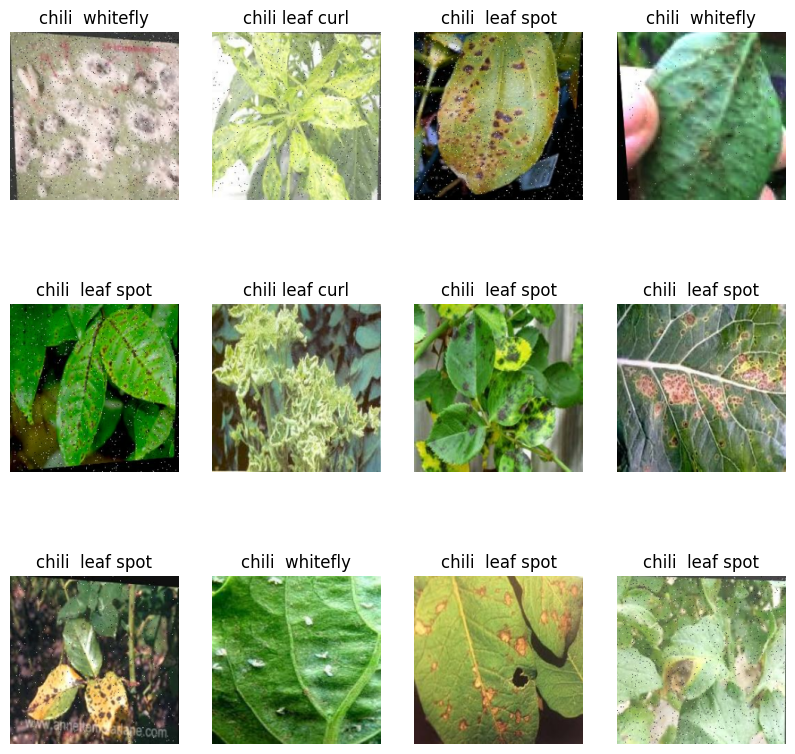

In [ ]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [ ]:
len(dataset) * 16

1088

### Data Splitting

In [ ]:
def data_split(data, train_split = 0.8, val_split = 0.15, 
               test_split = 0.05, shuffle=True, shuffle_size = 10000):
    data_size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size, seed=8)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_ds = data.take(train_size)
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = data_split(dataset)
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 54

Length of Validation Dataset is 10

Length of Testing Dataset is 4


### Image Augmentation

In [ ]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
type(train_ds)

tensorflow.python.data.ops.take_op._TakeDataset

In [ ]:
def resize(ds):
    resizing_rescaling = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(224,224),
        tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
    ])

    return resizing_rescaling

In [ ]:
resizing_rescaling = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

In [ ]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                            interpolation = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

    return data_augmentation

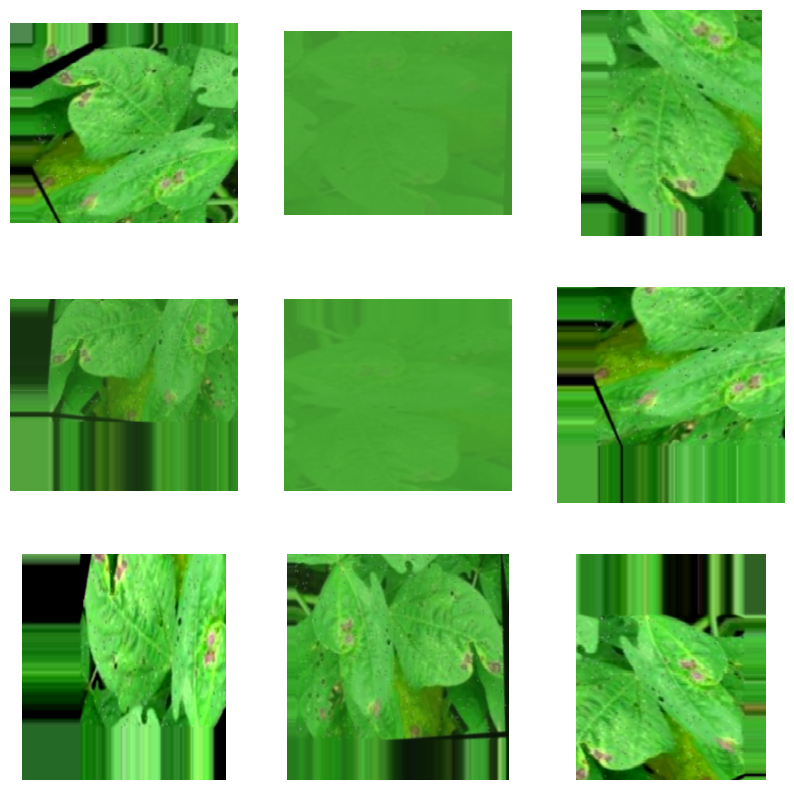

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                        interpolation = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

### Init Methods

In [ ]:
def conf_matrix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)

  ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

  ax.set_title('Confusion Matrix with labels\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  ax.set_xticks()
  ax.xaxis.set_ticklabels(source_classes, rotation=45)
  ax.yaxis.set_ticklabels(source_classes, rotation=45)

  plt.show()

### Model 5: ResNet50

In [ ]:
# Get a single batch from the dataset
batch = next(iter(train_ds))

input_data = batch[0]

# Print the shape of the data in the batch
print(input_data.shape)

(16, 224, 224, 3)


In [ ]:
len(classes)

4

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50

pre_trained_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

for layer in pre_trained_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
#x = data_augmentation(inputs)
#x = preprocess_input(x)
x = preprocess_input(inputs)
#x = data_augmentation(x)
#x = mbnet_v2(x, training=False)
x = pre_trained_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
predict = tf.keras.layers.Dense(4, activation = 'softmax')(x)

model5 = tf.keras.Model(inputs = inputs, outputs = predict)
#model5 = tf.keras.Model(inputs = pre_trained_model.input, outputs = predict)

In [ ]:
model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0     

In [ ]:
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True
        elif(logs.get('val_accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True

callbacks = EarlyStoppingAtMaxAccuracy()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

In [ ]:
model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [ ]:
history5 = model5.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    callbacks=[callbacks]
)

Epoch 1/100
54/54 [==============================] - 21s 136ms/step - loss: 1.1928 - accuracy: 0.4872 - val_loss: 0.6832 - val_accuracy: 0.7278
Epoch 2/100
54/54 [==============================] - 5s 79ms/step - loss: 0.7274 - accuracy: 0.7053 - val_loss: 0.4542 - val_accuracy: 0.8188
Epoch 3/100
54/54 [==============================] - 9s 147ms/step - loss: 0.6388 - accuracy: 0.7431 - val_loss: 0.4148 - val_accuracy: 0.8313
Epoch 4/100
54/54 [==============================] - 5s 82ms/step - loss: 0.5239 - accuracy: 0.8016 - val_loss: 0.3988 - val_accuracy: 0.8354
Epoch 5/100
54/54 [==============================] - 7s 104ms/step - loss: 0.4890 - accuracy: 0.8137 - val_loss: 0.3260 - val_accuracy: 0.8813
Epoch 6/100
54/54 [==============================] - 5s 79ms/step - loss: 0.4386 - accuracy: 0.8260 - val_loss: 0.3697 - val_accuracy: 0.8500
Epoch 7/100
54/54 [==============================] - 6s 99ms/step - loss: 0.3968 - accuracy: 0.8445 - val_loss: 0.2008 - val_accuracy: 0.9438
Ep

In [ ]:
model5.save('Resnet50Model_chili_v1.hdf5')

In [ ]:
score_train = model5.evaluate(train_ds)
score_valid = model5.evaluate(val_ds)
score_test = model5.evaluate(test_ds)

4/4 [==============================] - 1s 58ms/step - loss: 0.0694 - accuracy: 0.9844


In [ ]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

In [ ]:
print("Accuracy: {}".format(acc[-1]))
print("Validation Accuracy: {}".format(val_acc[-1]))

print("Loss: {}".format(loss[-1]))
print("Validation Loss: {}".format(val_loss[-1]))

Accuracy: 0.9454756379127502
Validation Accuracy: 0.9936708807945251
Loss: 0.16114507615566254
Validation Loss: 0.04814369976520538


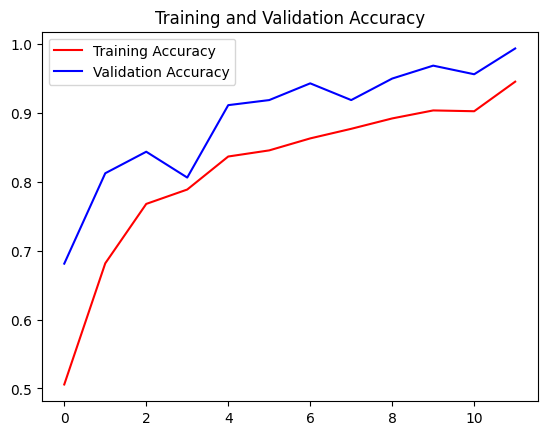

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

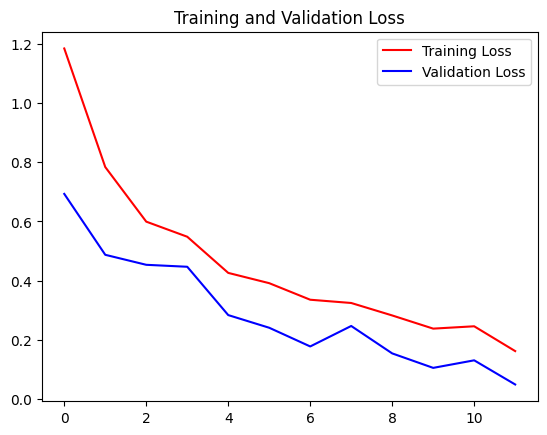

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

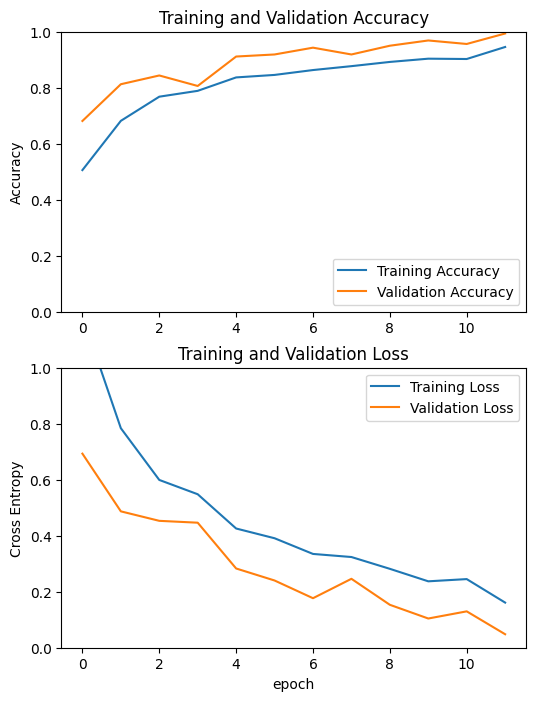

In [ ]:
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to predict
actual label: chili  whitefly
1/1 [==============================] - 1s 1s/step
predicted label: chili  whitefly


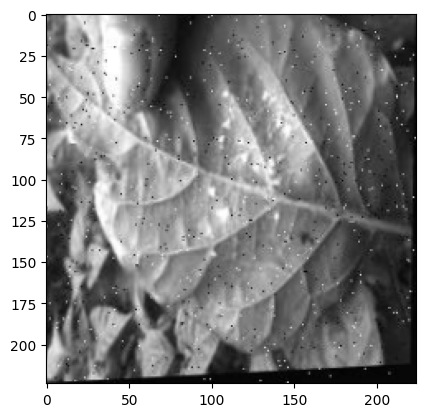

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model5.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model5,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [ ]:
pred_class = []
act_class = []
for images,labels in test_ds:
    for i in range(len(test_ds)):
        #ax = plt.subplot(3,4,i+1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model5,images[i].numpy())
        actual_class = classes[labels[i]]

        pred_class.append(predicted_class)
        act_class.append(actual_class)

1/1 [==============================] - 0s 24ms/step


In [ ]:
act_class

['chili  whitefly',
 'chili  leaf spot',
 'chili leaf curl',
 'chili  leaf spot',
 'chili  leaf spot',
 'chili yellowish',
 'chili yellowish',
 'chili yellowish',
 'chili yellowish',
 'chili leaf curl',
 'chili leaf curl',
 'chili leaf curl',
 'chili  whitefly',
 'chili  whitefly',
 'chili  whitefly',
 'chili leaf curl']

In [ ]:
cm = confusion_matrix(act_class, pred_class, labels=classes)

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=45)

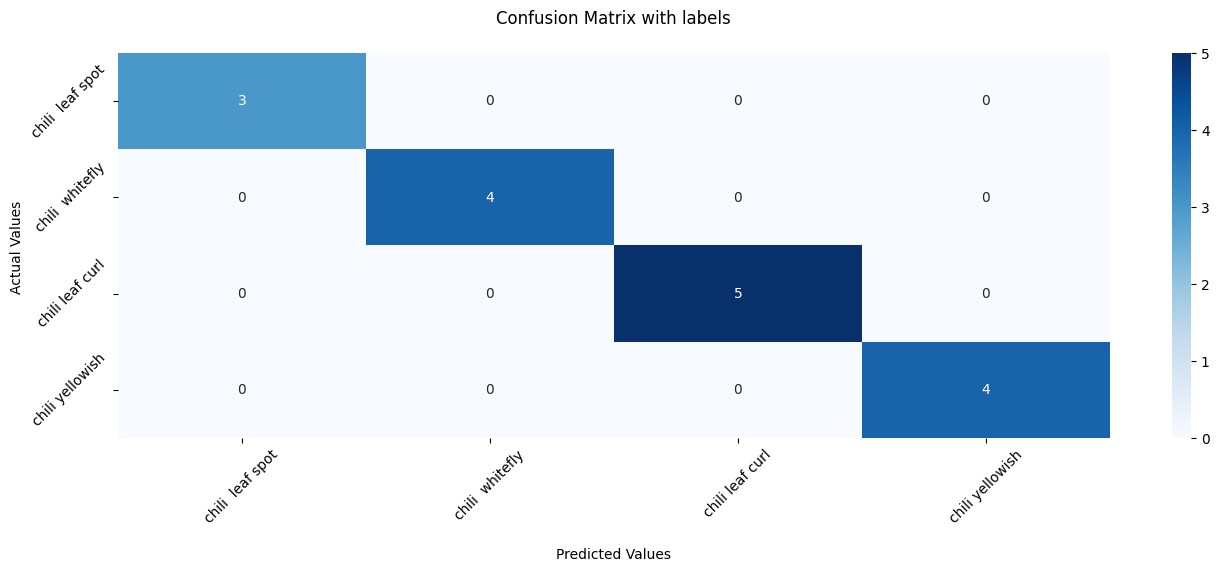

In [ ]:
plot_confusion_matrix(cm = cm, classes = classes)

In [ ]:
def saved_model(model_path, modelname, model):
  export_path = os.path.join(model_path, modelname)
  model.save(export_path)
  #tf.saved_model.save(model, export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# function to saved_model_history
def saved_model_history(model_path, modelname, history):
  with open(os.path.join(model_path, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# function to save tflite
def tflite_model_convert(model_path, tflite_path, modelname):

  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(model_path, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_path, "{}".format(modelname))

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "{}.tflite".format(modelname))
  
  label_file = os.path.join(tflite_dir, "{}.txt".format(modelname))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(classes))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [ ]:
model5.save('Resnet50Model_Potato_v1.h5')

In [ ]:
model_path = "/content/drive/MyDrive/FINAL_PROJECT/CABE/RESNET/saved_model"
os.makedirs(model_path, exist_ok=True)
modelname = "ResNet152V2_CHILI"
saved_model(model_path, modelname, model5)

Export path:  /content/drive/MyDrive/FINAL_PROJECT/CABE/RESNET/saved_model/ResNet152V2_CHILI
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']


In [ ]:
model_path = "/content/drive/MyDrive/FINAL_PROJECT/CABE/RESNET/saved_histori"
os.makedirs(model_path, exist_ok=True)
modelname = "ResNet152V2_CHILI"
saved_model_history(model_path, modelname, history5)

In [ ]:
# pemanggilan fungsi tflite
model_path = "/content/drive/MyDrive/FINAL_PROJECT/CABE/RESNET/saved_model"
modelname = "ResNet152V2_CHILI"
tflite_path = "/content/drive/MyDrive/FINAL_PROJECT/CABE/RESNET/saved_tflite"
os.makedirs(tflite_path, exist_ok=True)

tflite_model_convert(model_path, tflite_path, modelname)

Export path:  /content/drive/MyDrive/FINAL_PROJECT/CABE/RESNET/saved_tflite/ResNet152V2_CHILI
['ResNet152V2_CHILI.tflite', 'ResNet152V2_CHILI.txt']


In [ ]:
model5 = tf.keras.models.load_model('/content/drive/MyDrive/FINAL_PROJECT/CABE/RESNET/saved_model/ResNet152V2_CHILI')

Saving cabe leaf spot.jpg to cabe leaf spot.jpg
1/1 [==============================] - 1s 928ms/step
predictions :  [[9.9998844e-01 1.1464194e-05 1.2087080e-08 8.2153029e-08]]
predicted label: chili  leaf spot


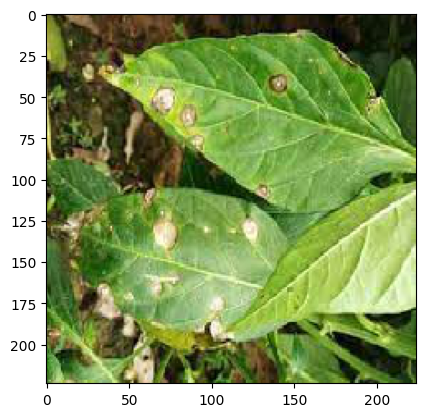

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

Saving cabe whitefly 5.jpg to cabe whitefly 5.jpg
1/1 [==============================] - 0s 24ms/step
predictions :  [[2.3387120e-06 9.9999595e-01 2.5271316e-09 1.6176073e-06]]
predicted label: chili  whitefly


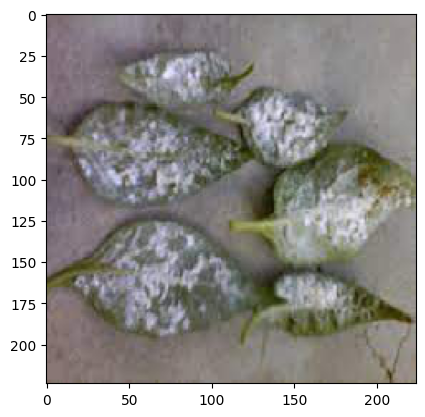

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

Saving chili bacterial leaf spot.jpg to chili bacterial leaf spot.jpg
1/1 [==============================] - 0s 98ms/step
predictions :  [[1.0000000e+00 8.2713516e-09 6.3637334e-10 7.5536359e-09]]
predicted label: chili  leaf spot


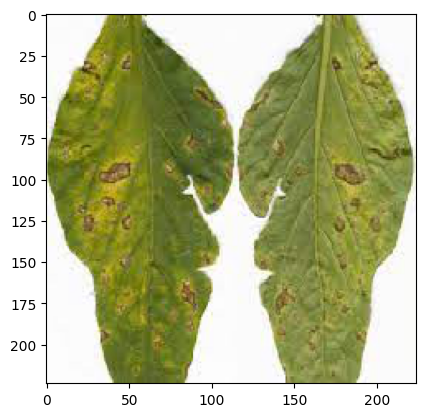

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload() 

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

Saving chili leaf curl 2.jpg to chili leaf curl 2.jpg
1/1 [==============================] - 0s 100ms/step
predictions :  [[1.8177190e-04 3.5490397e-02 9.3660122e-01 2.7726676e-02]]
predicted label: chili leaf curl


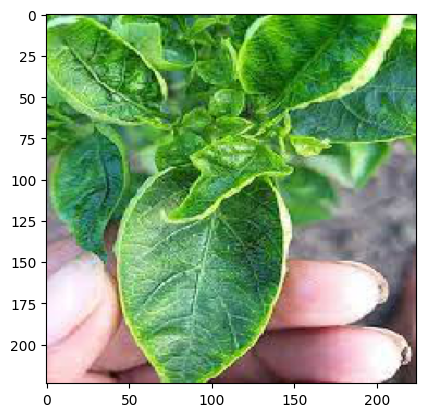

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

Saving chili leaf curl.jpg to chili leaf curl.jpg
1/1 [==============================] - 0s 24ms/step
predictions :  [[0.0034885  0.00313357 0.9341261  0.05925195]]
predicted label: chili leaf curl


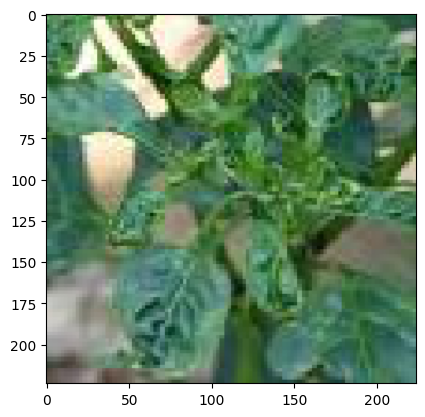

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

Saving chili leaf spot 5.jpg to chili leaf spot 5.jpg
1/1 [==============================] - 0s 24ms/step
predictions :  [[0.017465   0.00897548 0.9717078  0.00185168]]
predicted label: chili leaf curl


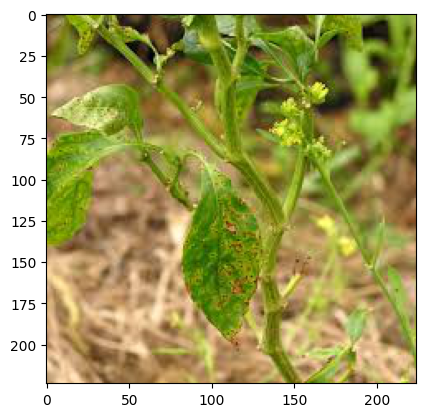

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

Saving chili whitefly.jpg to chili whitefly.jpg
1/1 [==============================] - 0s 86ms/step
predictions :  [[2.5538820e-05 9.9976617e-01 1.7132051e-04 3.7032609e-05]]
predicted label: chili  whitefly


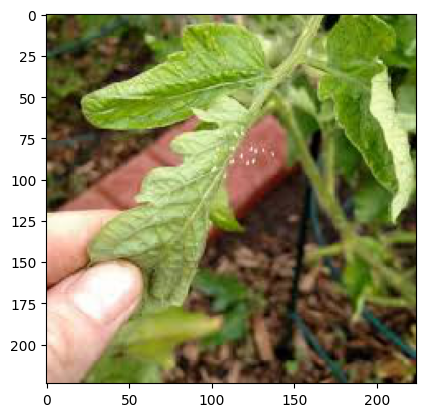

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

Saving chili whiterfly2.jpg to chili whiterfly2.jpg
1/1 [==============================] - 0s 35ms/step
predictions :  [[4.4144626e-06 9.2633758e-03 1.8102584e-04 9.9055123e-01]]
predicted label: chili yellowish


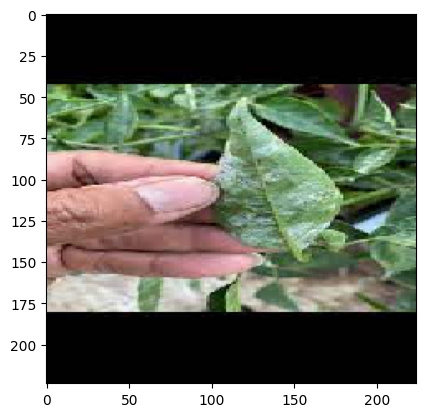

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

Saving chili yellow.jpg to chili yellow.jpg
1/1 [==============================] - 0s 24ms/step
predictions :  [[2.5938448e-06 4.0522837e-06 4.5652525e-04 9.9953687e-01]]
predicted label: chili yellowish


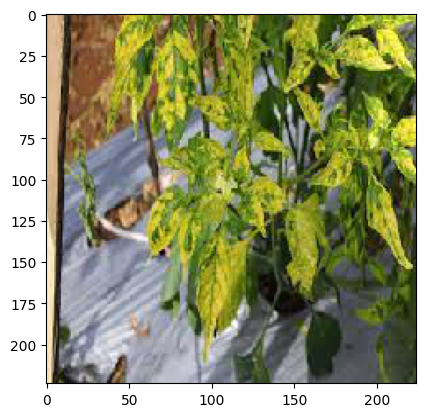

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

In [ ]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=1c3e461679debdcc0b3942a26f9d1edc620e6c73517504e0bc4d5ae1ae34518c
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators


In [ ]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st

@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/drive/MyDrive/FINAL_PROJECT/CABE/RESNET/Resnet50Model_chili.h5')
  
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
        size = (224,224)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        return prediction

if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


Overwriting app.py


In [ ]:


!pip install pyngrok
     


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!ngrok authtoken 2R12NT0LlNXEcVSjvEYLbm3ZxHj_7usTTVEcq2wnQpT1V7Ntn

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [ ]:

get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


In [ ]:
!streamlit run /content/app.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8503
  External URL: http://34.124.185.172:8503



In [ ]:
from pyngrok import ngrok
url=ngrok.connect(port=8501)
url

PyngrokNgrokHTTPError: ignored

In [ ]:
!cat /content/nohup.out